In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle

In [2]:
nlct_path = "/home/jturner/false_low_clouds_2023/Nighttime_Low_Cloud_Test/data/"

In [3]:
filename = 'goes_e_ntlc_2022_09_14_00H_00M'

file = open(nlct_path+filename, 'rb')
BTD = pickle.load(file)
file.close()

In [4]:
#---Northeast US
min_lon = -83
min_lat = 26
max_lon = -51
max_lat = 50

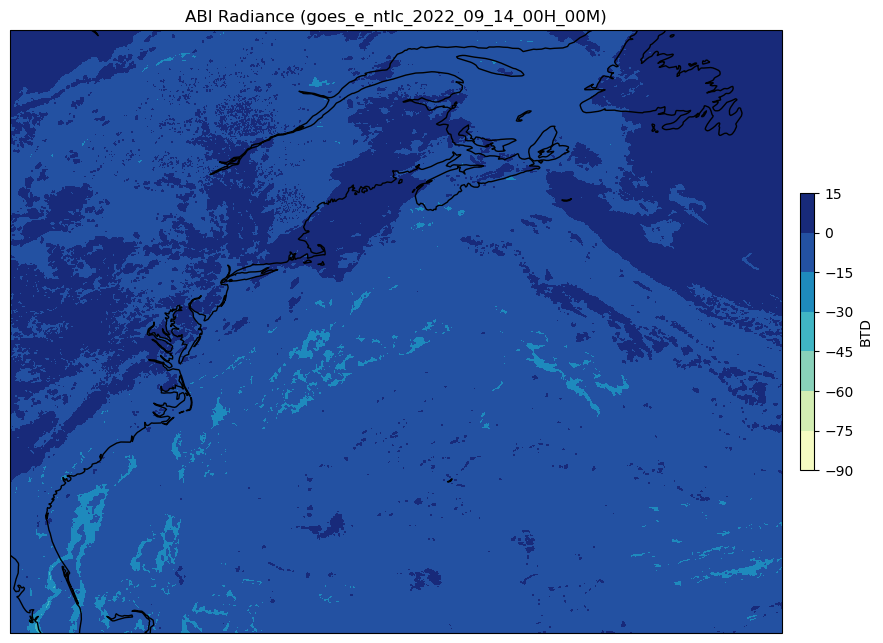

In [11]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlGnBu

ax.set_extent([min_lon, max_lon, min_lat, max_lat])
c=ax.contourf(BTD.lon, BTD.lat, BTD[0], cmap=cmap, extend='neither')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('ABI Radiance ('+filename+')')
clb.set_label('BTD')

ax.coastlines(resolution='50m', color='black', linewidth=1)